In [172]:
#downloading required libraries
!pip install matplotlib
!pip install seaborn
!pip install numpy
!pip install pandas
!pip install scikit-learn

IMPORTS

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

REQUIRED FUNCTIONS

In [4]:

# func for one-hot encoding (useless for CatBoost regressor)
def encode_text_columns(df: pd.DataFrame) -> pd.DataFrame:
    # copy df
    encoded_df = df.copy()
    # iterate DataFrame through columns
    for column in encoded_df.columns:
        # check data
        if encoded_df[column].dtype == object and column != 'timestamp':
            # one-hot encoding
            encoded_df[column], _ = pd.factorize(encoded_df[column])
    return encoded_df


def remove_columns_with_missing_data(df: pd.DataFrame, percent: int) -> pd.DataFrame:
    # copy df
    df_cleaned = df.copy()
    # iterate DataFrame through columns
    for column in df_cleaned.columns:
        # Calculate the percentage of missing data for each column
        missing_percent = (df_cleaned[column].isnull().sum() / len(df_cleaned)) * 100
        # If the percentage of missing data is greater than the specified X, delete the column
        if missing_percent > percent:
            df_cleaned.drop(column, axis = 1, inplace = True)
    return df_cleaned


def mean_filling_missing_data(df: pd.DataFrame) -> pd.DataFrame:
    # copy df
    df = df.copy()
    # iterate DataFrame through columns
    # Filling missing values for continuously columns with the mean value
    for column in df.select_dtypes(include = ['number']).columns:
        df[column].fillna(df[column].mean(), inplace = True)
    # Filling missing values for categorical columns with the most common value
    for column in df.select_dtypes(include = ['object']).columns:
        df[column].fillna(df[column].mode()[0], inplace = True)
    return df


def remove_corr_data(df: pd.DataFrame, threshold: float) -> pd.DataFrame:
    # Creating corr matrix
    df1 = df.copy()
    df = encode_text_columns(df.copy())
    try:
        del df['timestamp']
    except KeyError:
        pass
    correlation_matrix = df.corr().abs()

    # Finding the indices of columns with correlations above the threshold
    above_threshold_vars = {}
    for col in correlation_matrix:
        above_threshold_vars[col] = list(correlation_matrix.index[(1 > correlation_matrix[col]) & (correlation_matrix[col] > threshold)])
    # Discard one of the columns from each pair with high correlation
    cols_to_drop = set()
    for col in above_threshold_vars:
        cols_to_drop.update(set(above_threshold_vars[col]) - {col})
    # Del columns
    df_reduced = df1.drop(columns=cols_to_drop)
    return df_reduced


def construct_heatmap(df: pd.DataFrame) -> None:
    # Construct heatmap and corr matrix
    corr_matrix = encode_text_columns(df)
    try:
        del corr_matrix['timestamp']
    except:
        pass
    sns.heatmap(corr_matrix.corr())




def plot_data(df):
    for column in df.columns:
        if pd.api.types.is_integer_dtype(df[column]):
            # Construct a histogram for integer values
            df[column].hist()
            plt.title(f'Histogram of {column}')
            plt.xlabel('Value')
            plt.ylabel('Number of objects')
            plt.show()
        elif pd.api.types.is_float_dtype(df[column]):
            # Construct a distribution graph for continuous values
            sns.histplot(df[column], kde=True)
            plt.title(f'Distribution of data in the {column} column')
            plt.xlabel('Value')
            plt.ylabel('Density')
            plt.show()
            
def split_into_price_ranges(df, N):
    # Check that N is not greater than the number of objects in the DataFrame
    if N > len(df):
        raise ValueError("N не может быть больше количества объектов в DataFrame")
    
    #   Using qcut to split into groups
    df['price_group'] = pd.qcut(df['price_doc'], q=N, labels=[i for i in range(N)])
    
    # Outputting intervals and class labels
    intervals = pd.qcut(df['price_doc'], q=N).unique()
    for interval in sorted(intervals):
        print(f"Интервал: {interval}, Метка класса: {df[df['price_doc'].between(interval.left, interval.right)]['price_group'].iloc[0]}")
    
    # Returning a new dataset
    return df

def visualize_price_distribution(price_column: pd.Series) -> None:
    plt.figure(figsize=(10, 6))
    plt.hist(price_column, bins=60, color='blue', edgecolor='black')
    plt.title('Распределение цен на недвижимость')
    plt.xlim(0,30*10**6)
    plt.xlabel('Цена')
    plt.ylabel('Количество объектов')
    plt.grid(True)
    plt.show()


READING DATASETS

In [5]:
#reading csv files
train_df = pd.read_csv("datasets/train.csv", index_col=0)
macro_df = pd.read_csv("datasets/macro.csv")

EDA

In [6]:
#information about datasets
for dataset in [train_df, macro_df]:
    print(dataset.info())
    print('-'*100)

<class 'pandas.core.frame.DataFrame'>
Index: 30471 entries, 1 to 30473
Columns: 291 entries, timestamp to price_doc
dtypes: float64(119), int64(156), object(16)
memory usage: 67.9+ MB
None
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 100 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   timestamp                                   2484 non-null   object 
 1   oil_urals                                   2484 non-null   float64
 2   gdp_quart                                   2394 non-null   float64
 3   gdp_quart_growth                            2394 non-null   float64
 4   cpi                                         2453 non-null   float64
 5   ppi                                         2453 non-null   float64
 6   gdp_deflator 

In [7]:
train_df.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
id,,,,,,,,,,,,,,,,,,,,,
1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [8]:
macro_df.head()

,timestamp,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,2010-01-01,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
1,2010-01-02,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
2,2010-01-03,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
3,2010-01-04,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.905,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
4,2010-01-05,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.836,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN


MERGING DATASETS  

In [9]:
df = pd.merge(train_df, macro_df,)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Columns: 390 entries, timestamp to apartment_fund_sqm
dtypes: float64(213), int64(158), object(19)
memory usage: 90.7+ MB


In [10]:
df.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
1,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
2,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
3,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
4,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0


In [11]:
df.isnull().sum()

timestamp                          0
full_sq                            0
life_sq                         6383
floor                            167
max_floor                       9572
                               ...  
bandwidth_sports                   0
population_reg_sports_share     3239
students_reg_sports_share      16901
apartment_build                 3239
apartment_fund_sqm                 0
Length: 390, dtype: int64

In [12]:
df = remove_columns_with_missing_data(df, 5)
df.shape

(30471, 310)

In [ ]:
df = mean_filling_missing_data(df)
df.describe()

CONSTRUCT HEATMAP AND CORR MATRIX

In [14]:
construct_heatmap(df)

NameError: name 'sns' is not defined

REMOVE EXTRA DATA

In [15]:
df = remove_corr_data(df,0.6)
df.shape
df

,timestamp,full_sq,floor,product_type,school_education_centers_top_20_raion,healthcare_centers_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,...,mosque_count_500,leisure_count_500,price_doc,balance_trade_growth,average_provision_of_build_contract_moscow,deposits_growth,income_per_cap,rent_price_4+room_bus,rent_price_2room_eco,rent_price_1room_eco
0,2011-08-20,43,4.0,Investment,0,1,no,no,no,no,...,0,0,5850000,10.1,6.74,0.009740,42688.6,136.11,36.77,29.07
1,2011-08-23,34,3.0,Investment,0,1,no,no,no,no,...,0,0,6000000,10.1,6.74,0.009740,42688.6,136.11,36.77,29.07
2,2011-08-27,43,2.0,Investment,0,1,no,no,no,yes,...,0,0,5700000,10.1,6.74,0.009740,42688.6,136.11,36.77,29.07
3,2011-09-01,89,9.0,Investment,0,1,no,no,no,no,...,0,0,13100000,10.1,6.74,0.009607,40311.3,155.22,37.73,30.63
4,2011-09-05,77,4.0,Investment,0,4,no,no,no,yes,...,0,2,16331452,10.1,6.74,0.018590,40311.3,155.22,37.73,30.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30466,2015-06-30,44,7.0,Investment,0,1,no,yes,no,yes,...,0,0,7400000,32.9,7.13,0.013085,60050.0,167.37,38.91,30.29
30467,2015-06-30,86,3.0,Investment,1,3,no,no,no,yes,...,0,1,25000000,32.9,7.13,0.013085,60050.0,167.37,38.91,30.29
30468,2015-06-30,45,10.0,OwnerOccupier,0,0,no,no,no,no,...,0,0,6970959,32.9,7.13,0.013085,60050.0,167.37,38.91,30.29
30469,2015-06-30,64,5.0,Investment,0,2,no,no,no,yes,...,0,0,13500000,32.9,7.13,0.013085,60050.0,167.37,38.91,30.29


In [16]:
df.describe()

,full_sq,floor,school_education_centers_top_20_raion,healthcare_centers_raion,ID_metro,green_zone_km,industrial_km,cemetery_km,water_km,big_road1_km,...,mosque_count_500,leisure_count_500,price_doc,balance_trade_growth,average_provision_of_build_contract_moscow,deposits_growth,income_per_cap,rent_price_4+room_bus,rent_price_2room_eco,rent_price_1room_eco
count,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,...,30471.000000,30471.000000,3.047100e+04,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000
mean,54.214269,7.670803,0.109678,1.320895,72.484198,0.300511,0.768831,2.314765,0.690947,1.881276,...,0.004890,0.070592,7.123035e+06,22.612130,6.416008,0.010073,55778.022835,163.273194,41.012331,32.638114
std,38.031487,5.305390,0.333328,1.492903,54.902277,0.298402,0.717953,1.451071,0.434919,1.297188,...,0.069758,0.386393,4.780111e+06,18.372021,0.296318,0.016796,13041.480788,20.473868,4.171537,4.227862
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.006707,0.000364,...,0.000000,0.000000,1.000000e+05,4.600000,5.960000,-0.020356,33194.000000,100.080000,0.100000,2.310000
25%,38.000000,3.000000,0.000000,0.000000,27.000000,0.100951,0.288289,1.334801,0.339637,0.779029,...,0.000000,0.000000,4.740002e+06,7.600000,6.180000,0.000815,47334.000000,149.100000,40.830000,32.610000
50%,49.000000,7.000000,0.000000,1.000000,53.000000,0.214336,0.576464,1.968520,0.621221,1.724121,...,0.000000,0.000000,6.274411e+06,16.800000,6.390000,0.007563,52740.400000,160.690000,41.440000,33.100000
75%,63.000000,11.000000,0.000000,2.000000,108.000000,0.415498,1.041085,3.089480,0.963865,2.806196,...,0.000000,0.000000,8.300000e+06,32.900000,6.650000,0.022422,58779.100000,174.220000,42.100000,34.330000
max,5326.000000,77.000000,2.000000,6.000000,223.000000,1.982448,14.048162,15.778710,2.827709,6.995416,...,1.000000,9.000000,1.111111e+08,75.800000,7.130000,0.073227,89252.000000,212.870000,43.850000,35.370000


In [17]:
construct_heatmap(df)

NameError: name 'sns' is not defined

In [18]:
set(df.dtypes)

{dtype('int64'), dtype('float64'), dtype('O')}

In [1]:
plot_data(df)

SAVE DATASET FOR REG_MODEL 

In [188]:
df.to_csv('datasets/out_dataset_2_porog_60.csv', index=False) 

ANALIZ DATA FOR CAT_DATASET

In [19]:
df['price_doc'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 30471 entries, 0 to 30470
Series name: price_doc
Non-Null Count  Dtype
--------------  -----
30471 non-null  int64
dtypes: int64(1)
memory usage: 238.2 KB


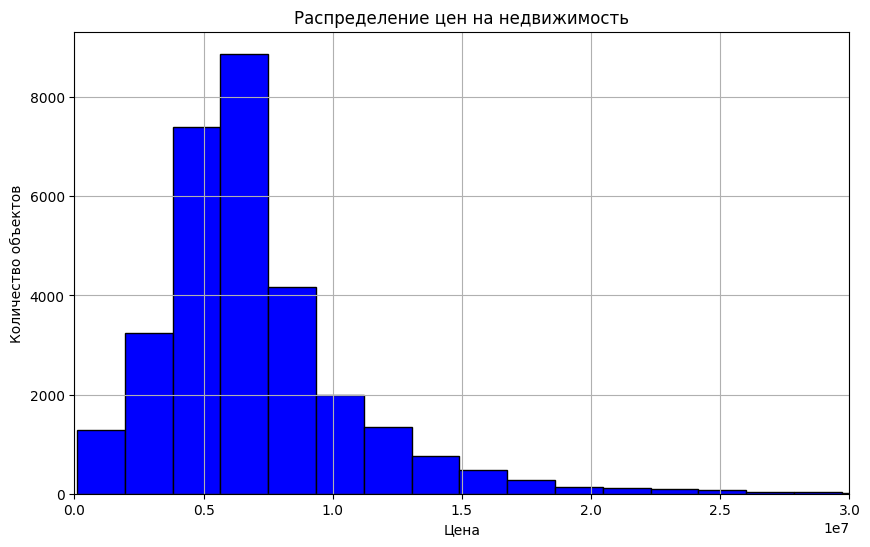

In [20]:
visualize_price_distribution(df['price_doc'])

In [22]:
new_df = split_into_price_ranges(df, 35)

Интервал: (99999.999, 1000000.0], Метка класса: 0
Интервал: (1000000.0, 1669748.4], Метка класса: 1
Интервал: (1669748.4, 2000000.0], Метка класса: 2
Интервал: (2000000.0, 2552421.0], Метка класса: 2
Интервал: (2552421.0, 3000000.0], Метка класса: 4
Интервал: (3000000.0, 3386385.2], Метка класса: 4
Интервал: (3386385.2, 3690164.0], Метка класса: 6
Интервал: (3690164.0, 3925806.0], Метка класса: 7
Интервал: (3925806.0, 4101772.4], Метка класса: 8
Интервал: (4101772.4, 4319500.0], Метка класса: 9
Интервал: (4319500.0, 4500000.0], Метка класса: 10
Интервал: (4500000.0, 4650000.0], Метка класса: 11
Интервал: (4650000.0, 4806371.0], Метка класса: 11
Интервал: (4806371.0, 4990000.0], Метка класса: 13
Интервал: (4990000.0, 5100000.0], Метка класса: 14
Интервал: (5100000.0, 5226412.0], Метка класса: 14
Интервал: (5226412.0, 5360000.0], Метка класса: 16
Интервал: (5360000.0, 5500000.0], Метка класса: 17
Интервал: (5500000.0, 5600000.0], Метка класса: 17
Интервал: (5600000.0, 5700000.0], Метка к

In [23]:
new_df['price_group']

0        21
1        22
2        19
3        46
4        48
         ..
30466    33
30467    49
30468    30
30469    46
30470    18
Name: price_group, Length: 30471, dtype: category
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49]

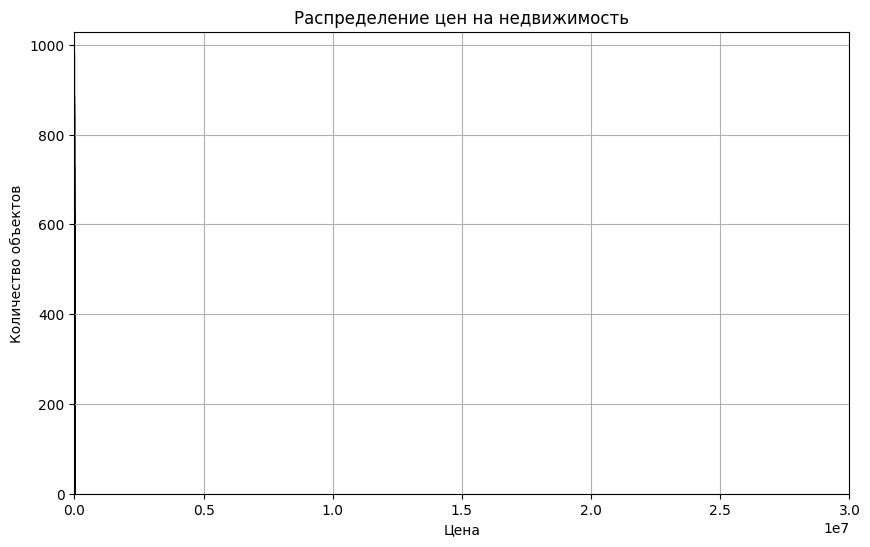

In [25]:
visualize_price_distribution(new_df['price_group'])

SAVE DATASET FOR CAT_MODEL

In [26]:
new_df.to_csv('datasets/out_dataset_3_class_porog_60.csv', index=False) 